<a href="https://colab.research.google.com/github/AI4Finance-Foundation/FinRL-Meta/blob/master/tutorials/1-Introduction/China_A_share_market_tushare.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Quantitative trading in China A stock market with FinRL

Install FinRL

In [1]:
!pip install git+https://github.com/AI4Finance-Foundation/FinRL.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/AI4Finance-Foundation/FinRL.git to /tmp/pip-req-build-h7fm55xg
  Running command git clone -q https://github.com/AI4Finance-Foundation/FinRL.git /tmp/pip-req-build-h7fm55xg
  Cloning https://github.com/quantopian/pyfolio.git to /tmp/pip-install-l7zc0s4r/pyfolio_97903f073f2b4c88b6f90bd1d5326fab
  Running command git clone -q https://github.com/quantopian/pyfolio.git /tmp/pip-install-l7zc0s4r/pyfolio_97903f073f2b4c88b6f90bd1d5326fab
  Cloning https://github.com/AI4Finance-Foundation/ElegantRL.git to /tmp/pip-install-l7zc0s4r/elegantrl_7b7417557d0540abbde7df30a47bd860
  Running command git clone -q https://github.com/AI4Finance-Foundation/ElegantRL.git /tmp/pip-install-l7zc0s4r/elegantrl_7b7417557d0540abbde7df30a47bd860
     |████████████████████████████████| 2.3 MB 55.2 MB/s 
     |████████████████████████████████| 234 kB 73.4 MB/s 
     |███████████████████████

Install other libraries

In [2]:
!pip install stockstats
!pip install tushare
#install talib
!wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz 
!tar xvzf ta-lib-0.4.0-src.tar.gz
import os
os.chdir('ta-lib') 
!./configure --prefix=/usr
!make
!make install
#!sudo make install # Sometimes it need root 
os.chdir('../')
!pip install TA-Lib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 130 kB 35.5 MB/s 
     |████████████████████████████████| 130 kB 77.2 MB/s 
     |████████████████████████████████| 200 kB 75.1 MB/s 
  Attempting uninstall: websocket-client
    Found existing installation: websocket-client 1.4.1
    Uninstalling websocket-client-1.4.1:
      Successfully uninstalled websocket-client-1.4.1
--2022-10-23 03:27:27--  http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
Resolving prdownloads.sourceforge.net (prdownloads.sourceforge.net)... 204.68.111.105
Connecting to prdownloads.sourceforge.net (prdownloads.sourceforge.net)|204.68.111.105|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.

In [3]:
%cd /
!git clone https://github.com/AI4Finance-Foundation/FinRL-Meta
%cd /FinRL-Meta/

/
Cloning into 'FinRL-Meta'...
remote: Enumerating objects: 7383, done.
remote: Counting objects: 100% (38/38), done.
remote: Compressing objects: 100% (26/26), done.
remote: Total 7383 (delta 19), reused 22 (delta 12), pack-reused 7345
Receiving objects: 100% (7383/7383), 132.90 MiB | 17.00 MiB/s, done.
Resolving deltas: 100% (4224/4224), done.
Checking out files: 100% (453/453), done.
/FinRL-Meta


##Import Modules

In [4]:
import warnings

warnings.filterwarnings("ignore")

import pandas as pd 
from IPython import display

display.set_matplotlib_formats("svg")

from meta import config 
from meta.data_processor import DataProcessor 
from main import check_and_make_directories 
from meta.data_processors.tushare import Tushare, ReturnPlotter 
from meta.env_stock_trading.env_stocktrading_China_A_shares import StockTradingEnv 
from agents.stablebaselines3_models import DRLAgent 
import os 
from typing import List 
from argparse import ArgumentParser 
from meta import config 
from meta.config_tickers import DOW_30_TICKER 
from meta.config import ( DATA_SAVE_DIR, TRAINED_MODEL_DIR, TENSORBOARD_LOG_DIR, RESULTS_DIR, INDICATORS, TRAIN_START_DATE, TRAIN_END_DATE, TEST_START_DATE, TEST_END_DATE, TRADE_START_DATE, TRADE_END_DATE, ERL_PARAMS, RLlib_PARAMS, SAC_PARAMS, ALPACA_API_KEY, ALPACA_API_SECRET, ALPACA_API_BASE_URL, )

import pyfolio
from pyfolio import timeseries

pd.options.display.max_columns = None

print("ALL Modules have been imported!")

ALL Modules have been imported!


##Create Folders

In [5]:
import os

''' 
use check_and_make_directories() to replace the following

if not os.path.exists("./datasets"): 
  os.makedirs("./datasets") 
if not os.path.exists("./trained_models"): 
  os.makedirs("./trained_models") 
if not os.path.exists("./tensorboard_log"): 
  os.makedirs("./tensorboard_log") 
if not os.path.exists("./results"): 
  os.makedirs("./results") 
'''

check_and_make_directories([DATA_SAVE_DIR, TRAINED_MODEL_DIR, TENSORBOARD_LOG_DIR, RESULTS_DIR])

##Download data, cleaning and feature engineering

In [6]:
ticker_list = ['600000.SH', '600009.SH', '600016.SH', '600028.SH', '600030.SH', '600031.SH', '600036.SH', '600050.SH', '600104.SH', '600196.SH', '600276.SH', '600309.SH', '600519.SH', '600547.SH', '600570.SH']
# At Oct.22 2022, trade date available span is [2020-04-22, 2022-10-21]
TRAIN_START_DATE = "2015-01-01"
TRAIN_END_DATE = "2020-07-01"
TRADE_START_DATE = "2020-07-01"
TRADE_END_DATE = "2022-10-01"

TIME_INTERVAL = "1d" 
kwargs = {} 
kwargs['token'] = '27080ec403c0218f96f388bca1b1d85329d563c91a43672239619ef5' 
p = DataProcessor(data_source='tushare', start_date=TRAIN_START_DATE, end_date=TRADE_END_DATE, time_interval=TIME_INTERVAL, **kwargs)

tushare successfully connected


###Download and Clean

In [7]:
p.download_data(ticker_list=ticker_list)

p.clean_data()

100%|██████████| 15/15 [01:02<00:00,  4.19s/it]


Shape of DataFrame:  (27932, 8)
Shape of DataFrame:  (28305, 8)


###Add technical indicator

In [8]:
p.add_technical_indicator(config.INDICATORS) 
p.clean_data()

#print(f"p.dataframe: {p.dataframe}")

tech_indicator_list:  ['macd', 'boll_ub', 'boll_lb', 'rsi_30', 'cci_30', 'dx_30', 'close_30_sma', 'close_60_sma']
indicator:  macd
indicator:  boll_ub
indicator:  boll_lb
indicator:  rsi_30
indicator:  cci_30
indicator:  dx_30
indicator:  close_30_sma
indicator:  close_60_sma
Succesfully add technical indicators
Shape of DataFrame:  (28260, 17)


##Split training dataset

In [9]:
train = p.data_split(p.dataframe, TRAIN_START_DATE, TRAIN_END_DATE) 

print(f"len(train.tic.unique()): {len(train.tic.unique())}")

len(train.tic.unique()): 15


In [10]:
print(f"train.tic.unique(): {train.tic.unique()}")

train.tic.unique(): ['600000.SH' '600009.SH' '600016.SH' '600028.SH' '600030.SH' '600031.SH'
 '600036.SH' '600050.SH' '600104.SH' '600196.SH' '600276.SH' '600309.SH'
 '600519.SH' '600547.SH' '600570.SH']


In [11]:
print(f"train.head(): {train.head()}")

train.head():          tic        date  index   open   high    low  close      volume  day  \
0  600000.SH  2015-01-08     45  15.87  15.88  15.20  15.25  3306271.72  3.0   
0  600009.SH  2015-01-08     46  20.18  20.18  19.73  20.00   198117.45  3.0   
0  600016.SH  2015-01-08     47  10.61  10.66  10.09  10.20  4851684.17  3.0   
0  600028.SH  2015-01-08     48   7.09   7.41   6.83   6.85  8190902.35  3.0   
0  600030.SH  2015-01-08     49  36.40  36.70  34.68  35.25  6376268.69  3.0   

       macd    boll_ub    boll_lb     rsi_30      cci_30       dx_30  \
0 -0.032571  16.617911  15.012089   6.058641 -125.593009   23.014040   
0 -0.016008  20.663897  19.736103  12.828915  -90.842491  100.000000   
0 -0.018247  10.957604   9.997396  11.862558  -99.887006  100.000000   
0 -0.008227   7.342000   6.743000  27.409248   36.578171   64.934862   
0  0.032910  36.576444  33.808556  61.517448   47.947020  100.000000   

   close_30_sma  close_60_sma  
0       15.8150       15.8150  
0       

In [12]:
print(f"train.shape: {train.shape}")

train.shape: (19995, 17)


In [13]:
stock_dimension = len(train.tic.unique()) 
state_space = stock_dimension * (len(config.INDICATORS) + 2) + 1 

print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")

Stock Dimension: 15, State Space: 151


##Train

In [14]:
env_kwargs = { "stock_dim": stock_dimension, "hmax": 1000, "initial_amount": 1000000, "buy_cost_pct": 6.87e-5, "sell_cost_pct": 1.0687e-3, "reward_scaling": 1e-4, "state_space": state_space, "action_space": stock_dimension, "tech_indicator_list": config.INDICATORS, "print_verbosity": 1, "initial_buy": True, "hundred_each_trade": True }

e_train_gym = StockTradingEnv(df=train, **env_kwargs)

In [15]:
env_train, _ = e_train_gym.get_sb_env() 

print(f"print(type(env_train)): {print(type(env_train))}")

<class 'stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv'>
print(type(env_train)): None


###DDPG

In [16]:
agent = DRLAgent(env=env_train) 
DDPG_PARAMS = { "batch_size": 256, "buffer_size": 50000, "learning_rate": 0.0005, "action_noise": "normal", } 
POLICY_KWARGS = dict(net_arch=dict(pi=[64, 64], qf=[400, 300])) 
model_ddpg = agent.get_model("ddpg", model_kwargs=DDPG_PARAMS, policy_kwargs=POLICY_KWARGS)

trained_ddpg = agent.train_model(model=model_ddpg, tb_log_name='ddpg', total_timesteps=10000)

{'batch_size': 256, 'buffer_size': 50000, 'learning_rate': 0.0005, 'action_noise': NormalActionNoise(mu=[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.], sigma=[0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1])}
Using cuda device
Logging to tensorboard_log/ddpg/ddpg_1
Episode: 2
day: 1332, episode: 2
begin_total_asset: 1000000.00
end_total_asset: 3706412.59
total_reward: 2706412.59
total_cost: 12975.96
total_trades: 19978
Sharpe: 0.984
Episode: 3
day: 1332, episode: 3
begin_total_asset: 1000000.00
end_total_asset: 1545489.16
total_reward: 545489.16
total_cost: 140.84
total_trades: 19980
Sharpe: 0.515
Episode: 4
day: 1332, episode: 4
begin_total_asset: 1000000.00
end_total_asset: 1005158.48
total_reward: 5158.48
total_cost: 75.52
total_trades: 19980
Sharpe: 0.353
Episode: 5
day: 1332, episode: 5
begin_total_asset: 1000000.00
end_total_asset: 1005158.51
total_reward: 5158.51
total_cost: 75.49
total_trades: 19980
Sharpe: 0.354
------------------------------------
| time/        

###A2C

In [17]:
agent = DRLAgent(env=env_train) 
model_a2c = agent.get_model("a2c")

trained_a2c = agent.train_model(model=model_a2c, tb_log_name='a2c', total_timesteps=50000)

{'n_steps': 5, 'ent_coef': 0.01, 'learning_rate': 0.0007}
Using cuda device
Logging to tensorboard_log/a2c/a2c_1
-------------------------------------
| time/                 |           |
|    fps                | 199       |
|    iterations         | 100       |
|    time_elapsed       | 2         |
|    total_timesteps    | 500       |
| train/                |           |
|    entropy_loss       | -21.3     |
|    explained_variance | -0.178    |
|    learning_rate      | 0.0007    |
|    n_updates          | 99        |
|    policy_loss        | 4.46      |
|    reward             | 0.9103077 |
|    std                | 1         |
|    value_loss         | 0.477     |
-------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 200       |
|    iterations         | 200       |
|    time_elapsed       | 4         |
|    total_timesteps    | 1000      |
| train/                |           |
|    entropy_

##Trade

In [18]:
trade = p.data_split(p.dataframe, TRADE_START_DATE, TRADE_END_DATE) 
env_kwargs = { "stock_dim": stock_dimension, "hmax": 1000, "initial_amount": 1000000, "buy_cost_pct": 6.87e-5, "sell_cost_pct": 1.0687e-3, "reward_scaling": 1e-4, "state_space": state_space, "action_space": stock_dimension, "tech_indicator_list": config.INDICATORS, "print_verbosity": 1, "initial_buy": False, "hundred_each_trade": True } 
e_trade_gym = StockTradingEnv(df=trade, **env_kwargs)

In [19]:
df_account_value, df_actions = DRLAgent.DRL_prediction(model=trained_ddpg, environment=e_trade_gym)

Episode: 2
day: 550, episode: 2
begin_total_asset: 1000000.00
end_total_asset: 1050486.31
total_reward: 50486.31
total_cost: 68.69
total_trades: 3300
Sharpe: 0.224
hit end!


In [20]:
df_actions.to_csv("action.csv", index=False) 
print(f"df_actions: {df_actions}")

df_actions:             600000.SH  600009.SH  600016.SH  600028.SH  600030.SH  600031.SH  \
date                                                                           
2020-07-01          0          0          0          0        800          0   
2020-07-02          0          0          0          0          0          0   
2020-07-03          0          0          0          0          0          0   
2020-07-06          0          0          0          0          0          0   
2020-07-07          0          0          0          0          0          0   
...               ...        ...        ...        ...        ...        ...   
2022-09-23          0          0          0          0          0          0   
2022-09-26          0          0          0          0        100          0   
2022-09-27          0          0          0          0          0          0   
2022-09-28          0          0          0          0          0          0   
2022-09-29          0       

##Backtest

###matplotlib inline

In [21]:
from matplotlib import pyplot as plt
plt.clf()

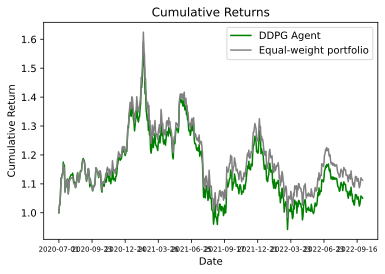

In [22]:
plotter = ReturnPlotter(df_account_value, trade, TRADE_START_DATE, TRADE_END_DATE)
plotter.plot()
plt.gcf()

本接口即将停止更新，请尽快使用Pro版接口：https://tushare.pro/document/2


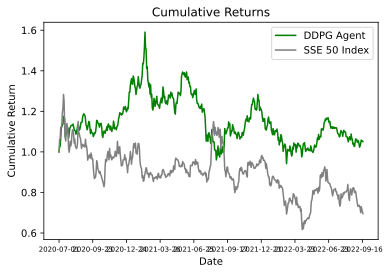

In [23]:
# ticket: SSE 50：000016
plt.clf()
plotter.plot("000016")
plt.gcf()

###CSI 300

In [24]:
baseline_df = plotter.get_baseline("399300")

本接口即将停止更新，请尽快使用Pro版接口：https://tushare.pro/document/2


In [25]:
daily_return = plotter.get_return(df_account_value)
daily_return_base = plotter.get_return(baseline_df, value_col_name="close")

perf_func = timeseries.perf_stats 
perf_stats_all = perf_func(returns=daily_return, factor_returns=daily_return_base, positions=None, transactions=None, turnover_denom="AGB")
print("==============DRL Strategy Stats===========")
print(f"perf_stats_all: {perf_stats_all}")

==============DRL Strategy Stats===========
perf_stats_all: Annual return          0.022782
Cumulative returns     0.050486
Annual volatility      0.294107
Sharpe ratio           0.223837
Calmar ratio           0.055886
Stability              0.181161
Max drawdown          -0.407646
Omega ratio            1.038672
Sortino ratio          0.316134
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.071471
Daily value at risk   -0.036793
Alpha                  0.103752
Beta                   1.071317
dtype: float64


In [26]:
daily_return = plotter.get_return(df_account_value)
daily_return_base = plotter.get_return(baseline_df, value_col_name="close")

perf_func = timeseries.perf_stats
perf_stats_all = perf_func(returns=daily_return_base, factor_returns=daily_return_base, positions=None, transactions=None, turnover_denom="AGB")

print("==============Baseline Strategy Stats===========")

print(f"perf_stats_all: {perf_stats_all}")

==============Baseline Strategy Stats===========
perf_stats_all: Annual return         -0.049112
Cumulative returns    -0.104264
Annual volatility      0.198623
Sharpe ratio          -0.154626
Calmar ratio          -0.140950
Stability              0.431349
Max drawdown          -0.348433
Omega ratio            0.974420
Sortino ratio         -0.212137
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.971044
Daily value at risk   -0.025146
Alpha                  0.000000
Beta                   1.000000
dtype: float64
